In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Black-Scholes and Heston Models

### Black-Scholes

In this notebook, we look at both the Black-Scholes and Heston Model for option pricing and simulate using Euler and Milstein discretisations. We will also look at a function for implied volatililty using the Black Scholes formula. Inspiration has been taken from the QuantPy youtube channel (https://www.youtube.com/quantpy) and for references of the mathematical content please see the pdf on the Github page.


First we look at the Black-Scholes model, which models the asset price $S(t)$ with the SDE:
\begin{align}
dS(t) = \mu S(t)dt + \sigma S(t)dW(t)
\end{align}

where $\mu$ and $\sigma$ are parameters represents mean rate of return and volatility respectively, $W(t)$ is Brownian motion under the standard probability measure $P$.

Using Girsanov's theorem and the fundamental theorem of asset pricing, one can use an equivalent probability measure $Q$, known as the risk-neutral measure, to ensure the absence of arbitrage. This transforms the SDE:
\begin{align}
dS(t) = r S(t) dt + \sigma S(t)dW^*(t)
\end{align}
where $r$ is the risk-free rate and $W^*(t)$ is Brownian motion under $Q$.

The key result from the risk-neutral measure is that for a derivative that pays $f(S(T))$ at time $T$ one can price it at time $0$ using the expectation and discounting:
\begin{align}
P(0) = e^{-rT}E^{Q}[f(S(t))]
\end{align}

Using this one then derives the Black-Scholes formula:
\begin{align}
S(0)\Phi(d_1) - e^{-rT}K\Phi(d_2)
\end{align}
where
\begin{align}
    d_1 &= \frac{log(\frac{S(0)}{K}) +(r + \frac{\sigma^2}{2})T}{\sigma\sqrt{T}}\\
    d_2 &= d_1 - \sigma\sqrt{T}
\end{align}
and $K$ is the strike price.

In [3]:
def black_scholes(s_0, k, r, sigma, t):
    d1 = (np.log(s_0/k)+(r+((sigma**2)/2))*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma* np.sqrt(t)
    p = s_0*norm.cdf(d1) - np.exp(-r*t)*k*norm.cdf(d2)
    return p

A defining feature of the Black-Scholes formula is constant volatility. When one looks at options in the market, one can calculate implied volatility which is the volatility required for Black-Scholes to give the market price. An interesting result of these calculations is the idea of a volatility smile, where the more a call/put option is out/in the money the higher the implied volatility.

Calculating implied volatility can be done via the Newton-Raphson method:

In [4]:
def implied_volatility(s_0, k, r, t, price, guess=0.5):
    x1 = guess

    while abs(price - black_scholes(s_0, k, r, x1, t))>0.0001:
        d1 = (np.log(s_0/k)+(r+((x1**2)/2))*t)/(x1*np.sqrt(t))
        d2 = d1 - x1* np.sqrt(t)
        d3 = (-1/(x1**2))*(np.log(s_0/k)/np.sqrt(t) + np.sqrt(t)) + np.sqrt(t)/2 
        d4 = d3 - np.sqrt(t)
        deriv = norm.pdf(d1)*s_0*d3 - np.exp(-r*t)*k*d4*norm.pdf(d2)
        x1 = x1 - (black_scholes(s_0, k, r, x1, t) - price)/deriv


    return x1

Let's consider a call option with the following parameters: $S(0) = 30$ , $K=28$, $r = 0.025$ and $T=0.5$. Then at various prices we can find the implied volatility:

In [5]:
implied_volatility(30, 28, 0.025, 0.5, 5), implied_volatility(30, 28, 0.025, 0.5, 3), implied_volatility(30, 28, 0.025, 0.5, 2)

/var/folders/ys/6hj5_p353ps5l3jrzlkd38cm0000gn/T/ipykernel_7161/2056755208.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  x1 = x1 - (black_scholes(s_0, k, r, x1, t) - price)/deriv
/var/folders/ys/6hj5_p353ps5l3jrzlkd38cm0000gn/T/ipykernel_7161/1880068152.py:2: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(s_0/k)+(r+((sigma**2)/2))*t)/(sigma*np.sqrt(t))


(np.float64(0.45829629132327543),
 np.float64(0.1910689929584092),
 np.float64(-inf))

We observe the error here as given the parameters, there is no volatility low enough to price an option that cheap.

Now let's take a look at some sample paths of $S(t)$ through simulation. We use the Euler discretisation:
\begin{align}
S(t_{i+1}) = S(t_{i}) \exp\{(\mu - \frac{\sigma^2}{2})dt + \sigma W(dt)\}
\end{align}
The following code comes from QuantPy's video on simulating geometric Brownian motion.

In [11]:
mu, s_0, sigma, t = 0.0125, 1000, 0.2, 1

n = 10000 # discrete time steps
M = 50 # number of simulations
dt = t/n # t_{i+1} - t_{i}

The way this works is that we will create an array where each column is 1 simulation, so the number of rows is the number of time step in the interval [0,t] and the number of columns is the number of distinct simulations. First we can make an array of $\exp\{(\mu - \frac{\sigma^2}{2})dt + \sigma W(dt)\}$ entries and then cumulative product down the rows. We add a row of ones at the top such that the top row contains the same starting price.


In [12]:

St = np.exp((mu - (sigma**2)/2)*dt + sigma * np.random.normal(0,np.sqrt(dt),size=(M,n)).T )

St = np.vstack([np.ones(M), St])

St = s_0 * St.cumprod(axis=0)


Finally, we can plot the results

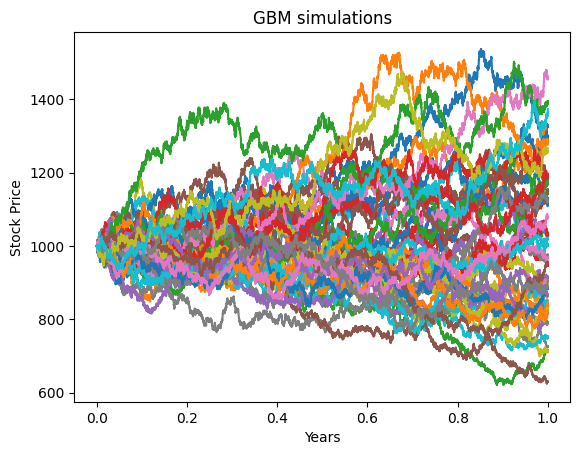

In [13]:
time = np.linspace(0,t,n+1)
tt = np.full(shape=(M,n+1), fill_value=time).T

plt.plot(tt,St)
plt.xlabel("Years")
plt.ylabel("Stock Price")
plt.title("GBM simulations")
plt.show()

We will compare this to the Heston Model later.

### Heston Model

Now we will look at the Heston Model which aims to address the constant volatility assumption by modelling volatility stochastically as well. We have the 2 SDEs:
\begin{align}
dS(t) = \mu S(t)dt + \sqrt{\nu(t)}S(t)dW(t) \\
d\nu(t) = \kappa (\theta -\nu(t))dt + \xi \sqrt{\nu(t)}dZ(t)
\end{align}
where $W(t)$ and $Z(t)$ are Brownian motion with correlation $\rho$.
We can see that $\nu(t)$ is modelled is modelled as being mean reverting to a mean $\theta$ at rate $\kappa$.
One again using Girsanov's theorem, there exists an equivalent risk-neutral measure $Q$ under which we have:
\begin{align}
dS(t) = rS(t)dt + \sqrt{\nu(t)}S(t)dW^*(t) \\
d\nu(t) = \kappa^Q (\theta^Q - \nu(t)) + \xi \sqrt{\nu(t)}dZ^*(t)
\end{align}
where under $Q$ $W^*(t)$ and $Z^*(t)$ are Brownian motion with correlation $\rho$ and $\kappa^Q = \kappa + \lambda$ and $\theta^Q = \frac{\kappa\theta}{\kappa + \lambda}$. Note that $\xi$ does not change.

The parameter $\lambda$ comes from the idea of a volatility risk premium, which could be described as an investors sensitivity to volatility.

There does exist a solution to this model and Heston presented this in his 1993 paper; however, here we will simulate these 2 process and observe the behaviour.

To simulate we will use a Milstein discretisation, which goes beyond an Euler discretisation by using extra information gleened from using Ito's formula:
\begin{align}
\nu(t + \Delta t) &= \nu(t) + \kappa(\theta - \nu(t))\Delta t + \xi \sqrt{\nu(t)}\sqrt{\Delta t}Z + \frac{1}{4}\xi^2 (Z^2 -1)\Delta t \\
    &= (\sqrt{\nu(t)} + \frac{1}{2}\xi\sqrt{\Delta t}Z)^2 + \kappa(\theta - \nu(t))\Delta t - \frac{1}{4}\xi^2 \Delta t
\end{align}
The main advantage of Milstein is that $\nu(t)$ becomes negative less often - it does still happen though so we take the absolute value. An alternative to that is $\max(\nu(t),0)$.

In [103]:
kappa, theta, nu_0, xi, t, rho, r, s_0  = 0.95, 0.04, 0.04, 0.15, 1, -0.3, 0.05, 1000

M = 100 # number of sims

n=10000 # time steps

dt = t/n #delta t


As before, we will work with arrays where each column is a separate simulation. First we create our correlated normals and will use norm1 and norm3 going forward.

In [104]:
norm1 = np.random.normal(0,1,size=(M,n)).T
norm2 = np.random.normal(0,1,size=(M,n)).T 
norm3 = rho * norm1 + np.sqrt(1-rho**2) * norm2

We set up the array and loop through implementing the discretisation.

In [105]:
simarray = np.ones((M,n)).T
simarray = np.vstack([nu_0*np.ones(M), simarray])

for i in range(n):
    for j in range(M):
        a = simarray[i,j]
        z = norm3[i,j]
        x = (np.sqrt(a) + 0.5 * xi * np.sqrt(dt) * z)**2 + (kappa * (theta - a) * dt) - 0.25 * xi**2 * dt
        simarray[i+1,j] = max(x,0)


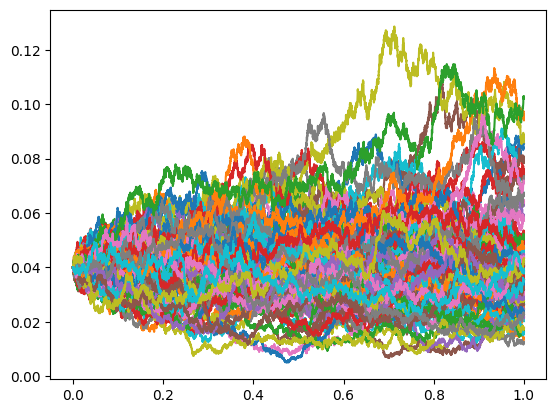

In [106]:
time = np.linspace(0,t,n+1)
tt = np.full(shape=(M,n+1), fill_value=time).T
plt.plot(tt,simarray)
plt.show()

In [107]:
np.average(simarray[n]) #checking the mean reverting nature of nu(t)

np.float64(0.041457474770587935)

Now we can simulate the stock process; this is very similar to the Black-Scholes simulating, notably using norm1 and the volatility process.

In [108]:
trunc = simarray[0:n,0:M]
St = np.exp((r - 0.5 * trunc)*dt + np.sqrt(trunc) * np.sqrt(dt) *  norm1 )
St = np.vstack([np.ones(M), St])
St = s_0 * St.cumprod(axis=0)

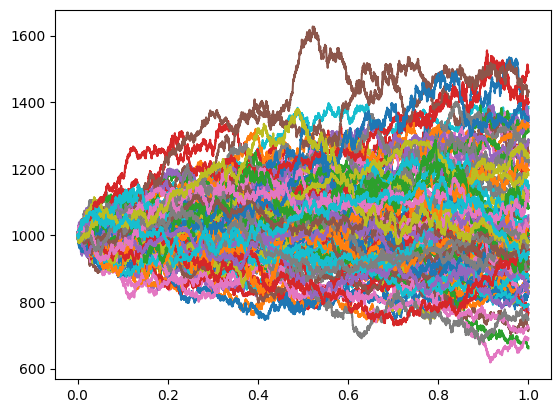

In [109]:
plt.plot(tt,St)
plt.show()

Comparing to the Black-Scholes, which is geometric Brownian motion, one can see how the Heston model can capture the rarer high volatility moments.